In [1]:
#Import necessary libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import re

In [12]:
#Read the dataset
df = pd.read_excel('day1_71c01958-464d-11ea-9162-1856804d508f_training_set_50k.xlsx')
df.head()

,Unnamed: 0,id,Title,Content,Labels
0,58951,Comp_58962,Christmas day 8 competition...,Autoglym Interior Shampoo 2 dirty floor mats s...,HAM
1,85348,Comp_85359,Are businesses allowed to charge someone more ...,Women's basic clothing items tend to be more e...,SPAM
2,23566,Comp_23573,If you could only wear one makeup brand for th...,What would you pick? Despite not owning a ton...,SPAM
3,41324,Comp_41335,High school w/ fucked up dress code,I need help from you guys! Recently I have st...,SPAM
4,32574,Comp_32582,Advice on finding an all-purpose jacket?,[removed],SPAM


In [13]:
df['Labels'].value_counts() #Check the distribution of labels

SPAM    31744
HAM     18256
Name: Labels, dtype: int64

In [14]:
df[pd.isna(df['Content'])]['Labels'].value_counts() #Check distribution of null values in Content column

SPAM    5271
HAM     1662
Name: Labels, dtype: int64

In [15]:
df[df['Content'] == '[removed]']['Labels'].value_counts()

SPAM    1946
HAM      594
Name: Labels, dtype: int64

In [16]:
df[df['Content'] == '[deleted]']['Labels'].value_counts()

SPAM    1582
HAM      346
Name: Labels, dtype: int64

### Preprocessing

In [17]:
df["text"] = df["Title"].map(str) + ' ' + df["Content"].map(str) #combine Title and Content columns

In [18]:
df['text'][102]

'To be very scared about getting my moles checked? Best to get it checked out. Seborrheic keratoses are "stuck on", greasy lesions that appear on the skin as we age. They\'re not moles and IIRC they do not turn cancerous. It\'s not common, but sometimes moles can turn cancerous. Melanoma can be quite dangerous. The good news is it\'s not very common. (For context: I have worked as a nurse for 12 years and although I teach now, I teach practicum regularly. I also used to work in a hospice. I saw ONE patient who died from melanoma. ONE.)'

In [19]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

lemmatizer = WordNetLemmatizer() 
stopwords = set(stopwords.words("english"))

In [20]:
def preprocessing(text):
    text = re.sub('[^a-zA-Z]', ' ', text) # Keep only alphabetical characters
    text = re.sub('\s+', ' ', text) # Remove multiple spaces
    text = text.lower().split() # Convert into lowercase and split into words
    text = [lemmatizer.lemmatize(word) for word in text if not word in stopwords and len(word)>3] #Remove stopwords
    text = " ".join(text) #join the words
    return text

In [21]:
df['preproc_text'] = df['text'].map(lambda x: preprocessing(x))

In [22]:
df['preproc_text'][102]

'scared getting mole checked best checked seborrheic keratoses stuck greasy lesion appear skin mole iirc turn cancerous common sometimes mole turn cancerous melanoma quite dangerous good news common context worked nurse year although teach teach practicum regularly also used work hospice patient died melanoma'

In [23]:
vocab_size = 20000

In [24]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=vocab_size)
tokenizer.fit_on_texts(df['preproc_text'])
sequences = tokenizer.texts_to_sequences(df['preproc_text'])

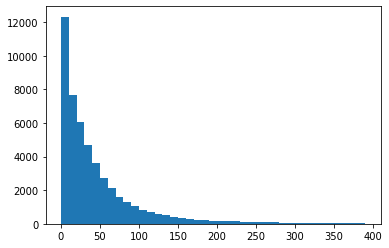

In [14]:
#Check the distribution of total number of words in sequences
total_words = [len(sequence) for sequence in sequences]
plt.hist(total_words, bins = np.arange(0,400,10))
plt.show()

In [26]:
max_length = 100 #Cut texts after 100 words
X = pad_sequences(sequences, maxlen=max_length, padding='post')

In [29]:
#Encode the labels 
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(df['Labels']) 

In [53]:
y

array([0, 1, 1, ..., 1, 1, 0])

### Split train and test sets

In [19]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=2020)

In [20]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(45000, 100) (45000,) (5000, 100) (5000,)


### Create Embedding Matrix

In [36]:
word_index = tokenizer.word_index
len(word_index)

101741

In [33]:
#Import Embeddings and create embedding dict
embeddings_index = {}
f = open('glove.6B/glove.6B.300d.txt', encoding="utf8")
#f = open('../w2v_embedding/cms_word2vec_embedding_300.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [37]:
from keras.layers import Embedding
from keras.initializers import Constant

#Create embedding layer
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i >= vocab_size: 
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### Model Building

In [38]:
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional, Dense, Dropout, Activation, Embedding
from keras.layers.normalization import BatchNormalization

model = Sequential()
model.add(Embedding(vocab_size, #20000
                    EMBEDDING_DIM, #300
                    input_length=max_length, #100
                    weights = [embedding_matrix], #20000 x 300 
                    trainable = False))
model.add(Bidirectional(LSTM(256)))
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 512)               1140736   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 7,208,577
Trainable params: 1,207,553
Non-trainable params: 6,001,024
____________________________________

In [27]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
lr = 3e-4
epochs = 10

adam = Adam(lr=lr)

model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])

In [28]:
model_chkpoint = ModelCheckpoint(filepath='spam_best_model.hdf5', save_best_only=True, save_weights_only=True)

In [29]:
reduce_lr = ReduceLROnPlateau(monitor='val_acc', 
                                patience=3, 
                                verbose=1, 
                                factor=0.2, 
                                min_lr=1e-7)

In [30]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['acc'])

In [31]:
model.fit(x_train, y_train, validation_split=0.05, epochs=epochs, callbacks=[reduce_lr, model_chkpoint])

Train on 42750 samples, validate on 2250 samples
Epoch 1/10
42750/42750 [==============================] - 535s 13ms/step - loss: 0.3412 - acc: 0.8559 - val_loss: 0.2640 - val_acc: 0.8933
Epoch 2/10
42750/42750 [==============================] - 530s 12ms/step - loss: 0.2438 - acc: 0.9005 - val_loss: 0.2962 - val_acc: 0.8844
Epoch 3/10
42750/42750 [==============================] - 515s 12ms/step - loss: 0.2090 - acc: 0.9144 - val_loss: 0.2267 - val_acc: 0.9138
Epoch 4/10
42750/42750 [==============================] - 643s 15ms/step - loss: 0.1763 - acc: 0.9263 - val_loss: 0.2537 - val_acc: 0.9124
Epoch 5/10
42750/42750 [==============================] - 580s 14ms/step - loss: 0.1407 - acc: 0.9428 - val_loss: 0.3154 - val_acc: 0.8920
Epoch 6/10
42750/42750 [==============================] - 484s 11ms/step - loss: 0.1041 - acc: 0.9570 - val_loss: 0.3607 - val_acc: 0.9004

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 7/10
42750/42750 [===========

In [33]:
y_preds = model.predict_classes(x_test)

In [34]:
y_preds

array([[0],
       [0],
       [1],
       ...,
       [1],
       [1],
       [0]], dtype=int32)

In [38]:
from sklearn.metrics import accuracy_score, confusion_matrix
accuracy_score(y_test, y_preds)

0.8998

In [39]:
confusion_matrix(y_test, y_preds)

array([[1527,  262],
       [ 239, 2972]])

### Model Predictions on Test Set

In [2]:
#Load the test set
df_test = pd.read_excel('day2_71c01958-464d-11ea-9162-1856804d508f_test_set_50k.xlsx')
df_test.head()

,Unnamed: 0,id,Title,Content
0,41151,Comp_41162,"[SELL/SWAP] THE BALM, MUFE LIPS & EYES, NARS, ...",[deleted]
1,49948,Comp_49959,Rose Leslie,NaN
2,64657,Comp_64668,"Itchy eye, dermatologist or optician?",I'd be very tempted to have a chat with an opt...
3,71724,Comp_71735,OTR II Rome: Beyonc√© Performed With Her Natur...,CourtneyGripling said: ‚Üë Now that we‚Äôve se...
4,89396,Comp_89407,"Teala Dunn part IV: new wig, new squad, still ...",ellesig said: ‚Üë View attachment 356135 View ...


In [3]:
#Combine Title and Content columns
df_test["text"] = df_test["Title"].map(str) + ' ' + df_test["Content"].map(str)

In [6]:
#Apply preprocessing method
df_test['preproc_text'] = df_test['text'].map(lambda x: preprocessing(x))

In [27]:
#Convert texts into sequences
test_sequences = tokenizer.texts_to_sequences(df_test['preproc_text'])

In [30]:
#pad sequences to have max length of 100
texts = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [40]:
#load the model weights
model.load_weights('spam_best_model.hdf5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          6000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 512)               1140736   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 7,208,577
Trainable params: 1,207,553
Non-trainable params: 6,001,024
____________________________________

In [41]:
#predict class labels
label_preds = model.predict_classes(texts)

In [48]:
label_preds

array([[1],
       [1],
       [1],
       ...,
       [0],
       [0],
       [0]], dtype=int32)

In [52]:
#Predicted class distribution
np.array(np.unique(label_preds, return_counts=True)).T

array([[    0, 17058],
       [    1, 32942]])

In [59]:
#Convert classes into labels
labels = ['HAM' if i == 0 else 'SPAM' for i in label_preds] 

In [60]:
#Add labels in the dataframe
df_test['labels'] = labels

In [61]:
df_test.head()

,Unnamed: 0,id,Title,Content,text,preproc_text,labels
0,41151,Comp_41162,"[SELL/SWAP] THE BALM, MUFE LIPS & EYES, NARS, ...",[deleted],"[SELL/SWAP] THE BALM, MUFE LIPS & EYES, NARS, ...",sell swap balm mufe lip eye nars clinique anas...,SPAM
1,49948,Comp_49959,Rose Leslie,NaN,Rose Leslie nan,rose leslie,SPAM
2,64657,Comp_64668,"Itchy eye, dermatologist or optician?",I'd be very tempted to have a chat with an opt...,"Itchy eye, dermatologist or optician? I'd be v...",itchy dermatologist optician tempted chat opti...,SPAM
3,71724,Comp_71735,OTR II Rome: Beyonc√© Performed With Her Natur...,CourtneyGripling said: ‚Üë Now that we‚Äôve se...,OTR II Rome: Beyonc√© Performed With Her Natur...,rome beyonc performed natural hair courtneygri...,SPAM
4,89396,Comp_89407,"Teala Dunn part IV: new wig, new squad, still ...",ellesig said: ‚Üë View attachment 356135 View ...,"Teala Dunn part IV: new wig, new squad, still ...",teala dunn part squad still white chasin elles...,SPAM


In [64]:
df_test.to_csv('predicted_data.csv', index=False)